# Exercises 6.9, 6.10: Windy Gridworld with King's Moves

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [2]:
np.random.seed(42)

In [3]:
def create_world():
    w = np.zeros((7,10), dtype=int)

    # Add winds 
    w[:, 0:3] = 0
    w[:, 3:6] = 1
    w[:, 6:8] = 2
    w[:, 8]   = 1
    w[:, 9]   = 0 
    
    return w

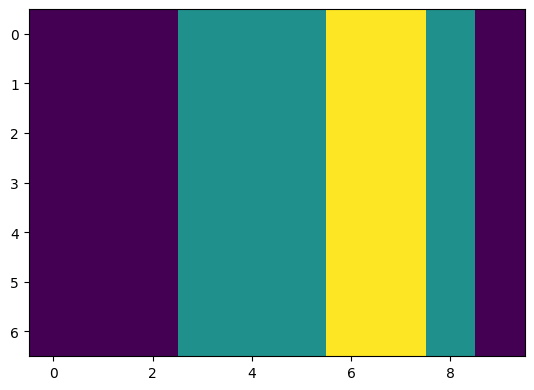

In [4]:
w = create_world()
plt.imshow(w)
plt.show()

In [5]:
w

array([[0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
       [0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
       [0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
       [0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
       [0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
       [0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
       [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]])

In [6]:
class WindWorld:

    HUMAN = 10

    def __init__(self, world, Q_ave = 0, sigma = 1, include_no_move_action = False):
        
        self.world = world
        self.shape = world.shape
        self.H, self.L = self.shape[0], self.shape[1]
    
        self.start = (3,0)
        self.goal = (3,7)
        
        # Options
        self.no_move = include_no_move_action


        self.nA = 8   # number of actions

        if self.no_move:
            self.nA += 1

        self.S_A_shape = self.shape + (self.nA,)

        self.action_to_dir = {0: (0,1),
                              1: (0,-1),
                              2: (1,0),
                              3: (-1,0),
                              4: (1,1),
                              5: (1,-1),
                              6: (-1,1),
                              7: (-1,-1),
                                }
        if self.no_move:
            self.action_to_dir[8] = (0,0)

        self.dir_to_action = {v:k for k,v in self.action_to_dir.items()}
        self.allowed_actions = {(x,y): self.get_allowed_actions((x,y)) for x in range(self.H) for y in range(self.L)} # allowed actions for a given state


        self.Q = self.Q_init(Q_ave, sigma)
        self.pi_greedy = np.argmax(self.Q, axis=-1)

        self.state = None # (x,y) - position on the grid

    
    def Q_init(self, Q_ave, sigma):

        Q = Q_ave + sigma*np.random.randn(*self.S_A_shape)
        
        # Set value of the Goal state to zero
        Q[self.goal] = 0

        # Maks disallowed actions at the borders of the world

        for x in range(self.shape[0]):
            for y in range(self.shape[1]):
                state = (x,y)
                allowed_actions = self.allowed_actions[state]

                for a in range(8):
                    if a not in allowed_actions:
                        Q[state + (a,)] = float('-inf')

        return Q
    

    def get_allowed_actions(self, state):

        x,y  = state
        H, L = self.shape

        allowed_actions = []

        for dx in range(-1,2):
            for dy in range(-1,2):
                x_next, y_next = x + dx, y + dy
                if (x_next, y_next) != (x,y) and 0 <= x_next < H and 0 <= y_next < L:
                    allowed_actions.append(self.dir_to_action[(dx,dy)])
        
        if self.no_move:
            allowed_actions.append(self.dir_to_action[(0,0)])
        
        return allowed_actions

    

    def eps_greedy(self, state, eps):

        p = np.random.rand()

        if p > eps:
            return self.pi_greedy[state]
        
        
        allowed_actions = self.allowed_actions[state]
        return np.random.choice(allowed_actions)
    
        
    def reset(self):
        self.state = self.start

    
    def sarsa(self, n_episodes, alpha, eps):


        curr_time_step = 0
        logs = [curr_time_step]  # current time at the end of each episode

        for i in tqdm(range(n_episodes)):

            self.reset()
            tot_reward = 0
            action = self.eps_greedy(self.state, eps)


            while self.state != self.goal:

                dx, dy = self.action_to_dir[action]
                tot_reward -= 1

                
                # Last term is the wind in negative x direction (upward).
                x_next = self.state[0] + dx - self.world[self.state]

                #  Clip to 0 to stay within bounds.
                x_next = max(0, x_next)    
                y_next = self.state[1] + dy
                
                next_state = (x_next, y_next)
                next_action = self.eps_greedy(next_state, eps)

              
                self.Q[self.state + (action,)] += alpha * (-1 + self.Q[next_state + (next_action,)] - self.Q[self.state + (action,)] )
                self.pi_greedy[self.state] = np.argmax(self.Q[self.state])

                self.state = next_state
                action = next_action

                curr_time_step += 1
                
            
            logs.append(curr_time_step)
        
        
        return logs 
    

    def generate_greedy_episode(self, render = True):

        self.reset()
        tot_reward = 0
        # action = self.pi_greedy[self.state]

        path = [self.state]

        while self.state != self.goal:

            # Get action
            action = self.pi_greedy[self.state]
            dx, dy = self.action_to_dir[action]

            # Get reward
            tot_reward -= 1

            # Next state
            x_next = max(0, self.state[0] + dx - self.world[self.state])    
            y_next = self.state[1] + dy
            
            self.state = (x_next, y_next)
            path.append(self.state)

        
        if render:
            
            print(f"Goal reached in {len(path)-1} steps.")

            world_map = self.world.copy()
            
            for state in path:
                world_map[state] = self.HUMAN

            plt.imshow(world_map)
            plt.show()


We start with considering 8 actions, but don't allow to make no movements at all.

In [7]:
g = WindWorld(w)

In [8]:
logs = g.sarsa(n_episodes = 600, alpha = 0.5, eps = 0.1)

  0%|          | 0/600 [00:00<?, ?it/s]

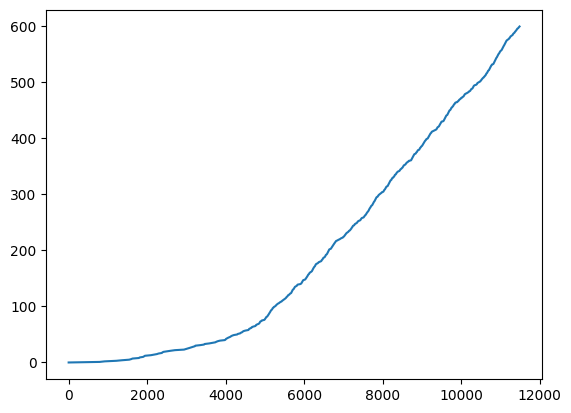

In [9]:
plt.plot(logs, range(len(logs)))
plt.show()

Goal reached in 7 steps.


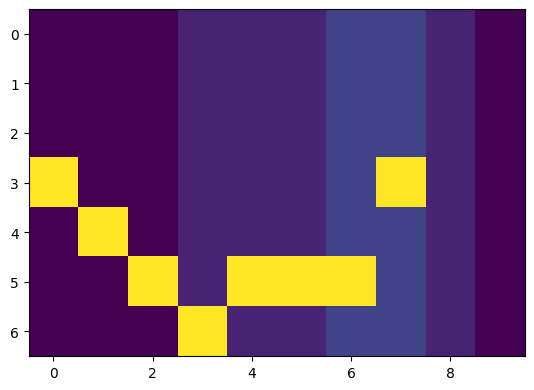

In [10]:
g.generate_greedy_episode()

Now let's allow to make no moves. That is 9 available actions.

In [11]:
g2 = WindWorld(w, include_no_move_action=True)

In [12]:
logs2 = g2.sarsa(n_episodes = 500, alpha = 0.5, eps = 0.1)

  0%|          | 0/500 [00:00<?, ?it/s]

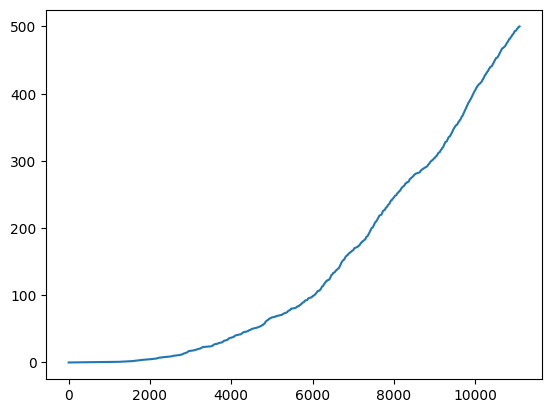

In [13]:
plt.plot(logs2, range(len(logs2)))
plt.show()

Goal reached in 7 steps.


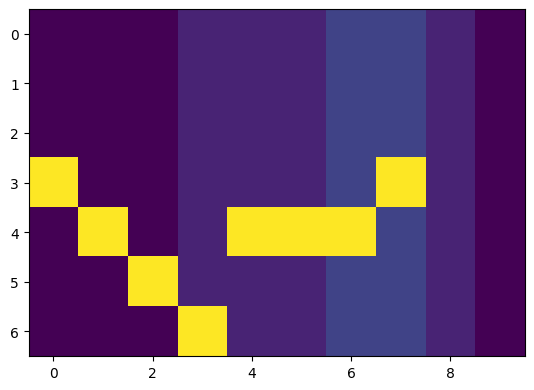

In [14]:
g2.generate_greedy_episode()

Both allowing and disallowing no movement action results in a path with 7 steps. While with only four allowed moves (up/down/right/left) the minimum number of steps is 15. 